In [23]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [24]:
# Load the dataset with Date parsed as datetime
df = pd.read_csv('data\\daily_expenses.csv', parse_dates=['Date'])

In [25]:
# Exclude 'Income' to focus on daily expenses
expense_df = df[df['Category'] != 'Income']

# Group by date to get total daily expense
daily_expense = expense_df.groupby('Date')['Amount_NTD'].sum().reset_index()
daily_expense.rename(columns={'Amount_NTD': 'DailyExpense'}, inplace=True)

# Sort by date (important if you want rolling features)
daily_expense.sort_values('Date', inplace=True)

# Drop daily expenses larger than 1000 NTD
daily_expense = daily_expense[daily_expense['DailyExpense'] <= 1000]

### Feature Engineering

In [26]:
# (a) Day of week (Monday=0, Sunday=6)
daily_expense['DayOfWeek'] = daily_expense['Date'].dt.dayofweek

# (b) Weekend indicator
daily_expense['IsWeekend'] = daily_expense['DayOfWeek'].isin([5, 6]).astype(int)

# (c) Month and Day of month
daily_expense['Month'] = daily_expense['Date'].dt.month
daily_expense['Day'] = daily_expense['Date'].dt.day

# (d) Lag features (Will be used later)
# Create a lag feature (previous day's expense)
daily_expense['Lag1'] = daily_expense['DailyExpense'].shift(1)
# Fill missing values (e.g., first day) with the mean or zero
daily_expense['Lag1'].fillna(daily_expense['DailyExpense'].mean(), inplace=True)


# (e) Rolling 7-day average of expenses (Will be used later)
# This can help the model learn from recent spending trends
daily_expense['Rolling7'] = (
    daily_expense['DailyExpense']
    .rolling(window=7, min_periods=1)
    .mean()
)

# (f) Log transform the target to reduce the impact of large spikes
daily_expense['LogExpense'] = np.log1p(daily_expense['DailyExpense'])

# Random Forest

### Base Function

In [27]:
# Function to train model and evaluate RMSE for a given feature set
def evaluate_feature_set(X, y, tscv=None, use_tscv=True):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Set up a simple parameter grid (or use your existing grid)
    rf = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 8, 16],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    if use_tscv:
        grid_search = GridSearchCV(
            rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1
        )
    else:
        grid_search = GridSearchCV(
            rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
        )

    grid_search.fit(X_train, y_train)
    print("Best Params from Grid Search:", grid_search.best_params_)
    
    best_rf = grid_search.best_estimator_
    y_pred_log = best_rf.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_exp = np.expm1(y_test)
    
    mse = mean_squared_error(y_test_exp, y_pred)
    rmse = np.sqrt(mse)
    return {'rmse': rmse, 'grid_search': grid_search, 'y_pred': y_pred, 'y_test': y_test_exp}

## Evaluate

### Without Lag1 and Rolling7

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

features_A = ['DayOfWeek', 'IsWeekend', 'Month', 'Day']  # without Lag1 and Rolling7

X = daily_expense[features_A]
y = daily_expense['LogExpense']

result = evaluate_feature_set(X, y, tscv, use_tscv=True)
rmse_A, best_params_A = result['rmse'], result['grid_search'].best_params_
best_rf_A = result['grid_search'].best_estimator_
y_pred_A, y_test_A = result['y_pred'], result['y_test']
feature_importance_A = result['grid_search'].best_estimator_.feature_importances_

print("Feature Set A (no Lag1, no Rolling7) RMSE:", rmse_A)

Best Params from Grid Search: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Feature Set A (no Lag1, no Rolling7) RMSE: 38.66275658792042


### With Lag1

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

features_B = ['DayOfWeek', 'IsWeekend', 'Month', 'Day', 'Lag1']  # with Lag1 only

X = daily_expense[features_B]
y = daily_expense['LogExpense']

result = evaluate_feature_set(X, y, tscv, use_tscv=True)
rmse_B, best_params_B = result['rmse'], result['grid_search'].best_params_
best_rf_B = result['grid_search'].best_estimator_
y_pred_B, y_test_B = result['y_pred'], result['y_test']
feature_importance_B = result['grid_search'].best_estimator_.feature_importances_

print("Feature Set B (with Lag1, no Rolling7) RMSE:", rmse_B)

Best Params from Grid Search: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100}
Feature Set B (with Lag1, no Rolling7) RMSE: 39.3385956464684


### With Rolling7

In [30]:
tscv = TimeSeriesSplit(n_splits=5)

features_C = ['DayOfWeek', 'IsWeekend', 'Month', 'Day', 'Rolling7']  # with Rolling7 only

X = daily_expense[features_C]
y = daily_expense['LogExpense']

result = evaluate_feature_set(X, y, tscv, use_tscv=True)
rmse_C, best_params_C = result['rmse'], result['grid_search'].best_params_
best_rf_C = result['grid_search'].best_estimator_
y_pred_C, y_test_C = result['y_pred'], result['y_test']
feature_importance_C = result['grid_search'].best_estimator_.feature_importances_

print("Feature Set C (no Lag1, with Rolling7) RMSE:", rmse_C)

Best Params from Grid Search: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Feature Set C (no Lag1, with Rolling7) RMSE: 37.275187253048614


### With Lag1 & Rolling7

In [31]:
tscv = TimeSeriesSplit(n_splits=5)

features_D = ['DayOfWeek', 'IsWeekend', 'Month', 'Day', 'Lag1', 'Rolling7']  # with both Lag1 and Rolling7

X = daily_expense[features_D]
y = daily_expense['LogExpense']

result = evaluate_feature_set(X, y, tscv, use_tscv=True)
rmse_D, best_params_D = result['rmse'], result['grid_search'].best_params_
best_rf_D = result['grid_search'].best_estimator_
y_pred_D, y_test_D = result['y_pred'], result['y_test']
feature_importance_D = result['grid_search'].best_estimator_.feature_importances_

print("Feature Set D (with Lag1, with Rolling7) RMSE:", rmse_D)

Best Params from Grid Search: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Feature Set D (with Lag1, with Rolling7) RMSE: 36.19773875656066


### Result

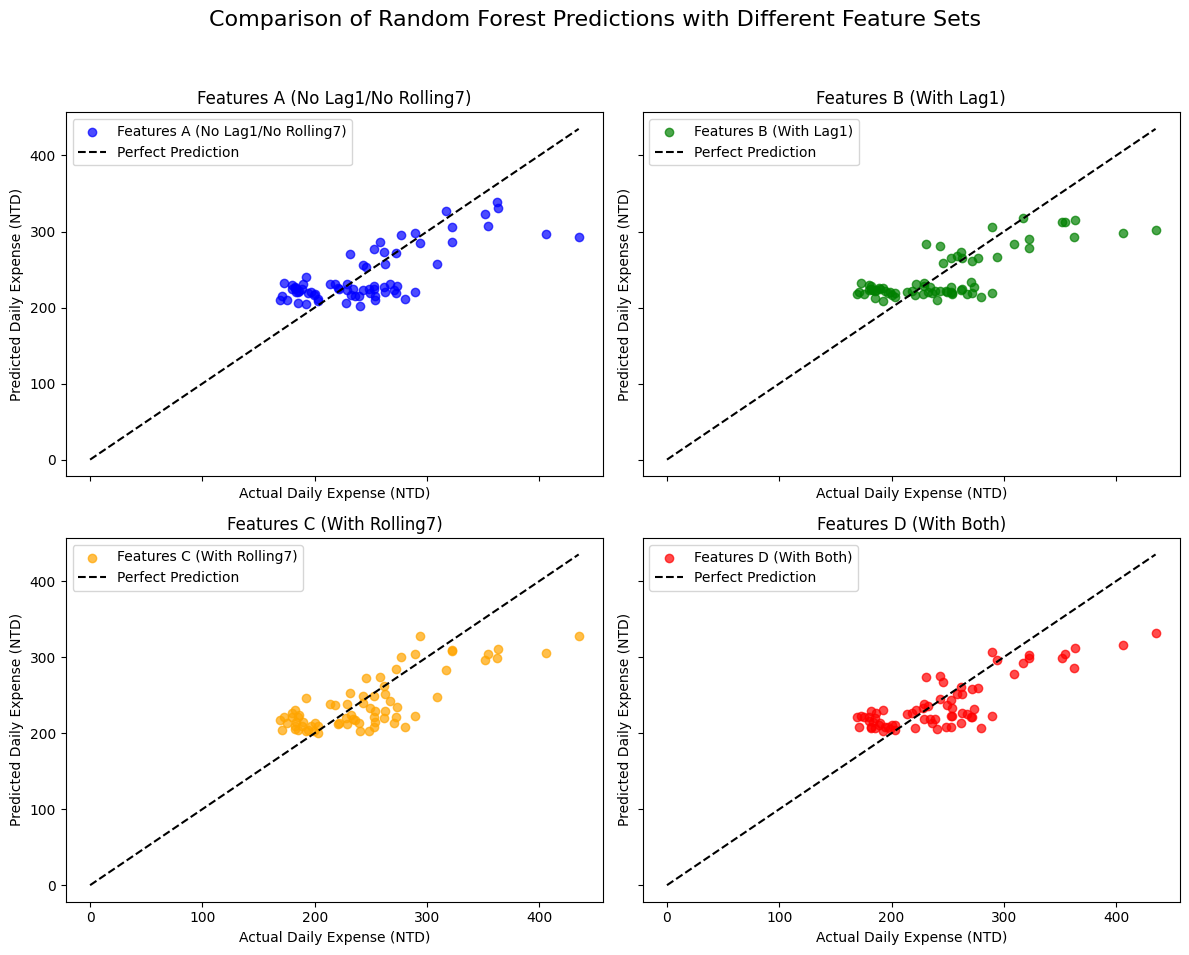

In [32]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

# List of (true values, predictions, label, color) for each feature set
plot_data = [
    (y_test_A, y_pred_A, 'Features A (No Lag1/No Rolling7)', 'blue'),
    (y_test_B, y_pred_B, 'Features B (With Lag1)', 'green'),
    (y_test_C, y_pred_C, 'Features C (With Rolling7)', 'orange'),
    (y_test_D, y_pred_D, 'Features D (With Both)', 'red'),
]

for ax, (y_test, y_pred, title, color) in zip(axes, plot_data):
    ax.scatter(y_test, y_pred, color=color, alpha=0.7, label=title)
    # Determine maximum value for perfect prediction line in each subplot
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'k--', label='Perfect Prediction')
    ax.set_xlabel('Actual Daily Expense (NTD)')
    ax.set_ylabel('Predicted Daily Expense (NTD)')
    ax.set_title(title)
    ax.legend()

fig.suptitle('Comparison of Random Forest Predictions with Different Feature Sets', fontsize=16)
plt.savefig('data\\experiment_result\\random_forest_comparison.png')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Feature Importance

In [33]:
# Feature Set A: Without Lag1 and Rolling7
feature_importance_df_A = pd.DataFrame({'Feature': features_A, 'Importance': feature_importance_A})
print("Feature Importances for Feature Set A (No Lag1/No Rolling7):")
print(feature_importance_df_A)
print("\n" + "="*50 + "\n")

# Feature Set B: With Lag1 only
feature_importance_df_B = pd.DataFrame({'Feature': features_B, 'Importance': feature_importance_B})
print("Feature Importances for Feature Set B (With Lag1):")
print(feature_importance_df_B)
print("\n" + "="*50 + "\n")

# Feature Set C: With Rolling7 only
feature_importance_df_C = pd.DataFrame({'Feature': features_C, 'Importance': feature_importance_C})
print("Feature Importances for Feature Set C (With Rolling7):")
print(feature_importance_df_C)
print("\n" + "="*50 + "\n")

# Feature Set D: With both Lag1 and Rolling7
feature_importance_df_D = pd.DataFrame({'Feature': features_D, 'Importance': feature_importance_D})
print("Feature Importances for Feature Set D (With Both Lag1 & Rolling7):")
print(feature_importance_df_D)


Feature Importances for Feature Set A (No Lag1/No Rolling7):
     Feature  Importance
0  DayOfWeek    0.406320
1  IsWeekend    0.282965
2      Month    0.144396
3        Day    0.166320


Feature Importances for Feature Set B (With Lag1):
     Feature  Importance
0  DayOfWeek    0.406350
1  IsWeekend    0.314623
2      Month    0.064919
3        Day    0.073103
4       Lag1    0.141005


Feature Importances for Feature Set C (With Rolling7):
     Feature  Importance
0  DayOfWeek    0.335043
1  IsWeekend    0.239466
2      Month    0.078241
3        Day    0.108969
4   Rolling7    0.238281


Feature Importances for Feature Set D (With Both Lag1 & Rolling7):
     Feature  Importance
0  DayOfWeek    0.292754
1  IsWeekend    0.229379
2      Month    0.054489
3        Day    0.079247
4       Lag1    0.130432
5   Rolling7    0.213698


### Cross Validation

In [34]:
# Function to perform cross-validation for a given feature set and best estimator
def cross_val_feature_set(features, best_rf):
    X_set = daily_expense[features]
    y_set = daily_expense['LogExpense']
    
    cv_scores = cross_val_score(
        best_rf,
        X_set,
        y_set,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    return rmse_scores, rmse_scores.mean(), rmse_scores.std()

In [35]:
# Perform cross-validation on each feature set using the best estimator from grid search
rmse_scores_A, mean_rmse_A, std_rmse_A = cross_val_feature_set(features_A, best_rf_A)
rmse_scores_B, mean_rmse_B, std_rmse_B = cross_val_feature_set(features_B, best_rf_B)
rmse_scores_C, mean_rmse_C, std_rmse_C = cross_val_feature_set(features_C, best_rf_C)
rmse_scores_D, mean_rmse_D, std_rmse_D = cross_val_feature_set(features_D, best_rf_D)

In [36]:
print("Cross-Validation RMSE for Feature Set A (No Lag1/No Rolling7):")
print(rmse_scores_A)
print("Mean RMSE:", mean_rmse_A)
print("Standard Deviation of RMSE:", std_rmse_A)
print("\n" + "="*50 + "\n")
print("Cross-Validation RMSE for Feature Set B (With Lag1):")
print(rmse_scores_B)
print("Mean RMSE:", mean_rmse_B)
print("Standard Deviation of RMSE:", std_rmse_B)
print("\n" + "="*50 + "\n")
print("Cross-Validation RMSE for Feature Set C (With Rolling7):")
print(rmse_scores_C)
print("Mean RMSE:", mean_rmse_C)
print("Standard Deviation of RMSE:", std_rmse_C)
print("\n" + "="*50 + "\n")
print("Cross-Validation RMSE for Feature Set D (With Both Lag1 & Rolling7):")
print(rmse_scores_D)
print("Mean RMSE:", mean_rmse_D)
print("Standard Deviation of RMSE:", std_rmse_D)

Cross-Validation RMSE for Feature Set A (No Lag1/No Rolling7):
[0.14123133 0.18620571 0.15099621 0.19368341 0.16927219]
Mean RMSE: 0.16827776916692772
Standard Deviation of RMSE: 0.019990040177141778


Cross-Validation RMSE for Feature Set B (With Lag1):
[0.13739528 0.17689063 0.15231579 0.19879546 0.16225005]
Mean RMSE: 0.16552944218569143
Standard Deviation of RMSE: 0.02103611466426487


Cross-Validation RMSE for Feature Set C (With Rolling7):
[0.12797353 0.17395989 0.14638658 0.17412378 0.15168051]
Mean RMSE: 0.15482485750497763
Standard Deviation of RMSE: 0.017553818642204157


Cross-Validation RMSE for Feature Set D (With Both Lag1 & Rolling7):
[0.12514251 0.16964064 0.14900217 0.17844627 0.1477058 ]
Mean RMSE: 0.1539874791836075
Standard Deviation of RMSE: 0.018652610616576897


In [37]:
result_df = pd.DataFrame({
    'feature_set': ['A', 'B', 'C', 'D'],
    'RMSE': [rmse_A, rmse_B, rmse_C, rmse_D],
    'best_params': [best_params_A, best_params_B, best_params_C, best_params_D],
    'best_rf': [best_rf_A, best_rf_B, best_rf_C, best_rf_D],
    'features': [features_A, features_B, features_C, features_D],
    'feature_importance': [feature_importance_A, feature_importance_B, feature_importance_C, feature_importance_D],
    'cross_validation_RMSE': [rmse_scores_A, rmse_scores_B, rmse_scores_C, rmse_scores_D],
    'cross_validation_RMSE_mean': [mean_rmse_A, mean_rmse_B, mean_rmse_C, mean_rmse_D],
    'cross_validation_RMSE_std': [std_rmse_A, std_rmse_B, std_rmse_C, std_rmse_D],
})

result_df.to_csv('data\\experiment_result\\random_forest_result.csv', index=False)

# K-Means Clustering

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [39]:
# Selecting features for clustering.
# We include some of the engineered features that capture temporal and trend information.
cluster_features = ['DayOfWeek', 'IsWeekend', 'Month', 'Day', 'Rolling7', 'Lag1']

In [40]:
# Create a subset of data for clustering.
X_cluster = daily_expense[cluster_features].copy()

# Standardize the features (recommended for K-Means).
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

In [41]:
# Determine the optimal number of clusters using the Elbow Method.
sse = []  # Sum of Squared Errors for each k
sil_scores = []
db_scores = []
ch_scores = []

k_values = range(2, 31)
for k in k_values:
    # Note: In scikit-learn 1.4+ use n_init='auto'
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_cluster_scaled)

    sil = silhouette_score(X_cluster_scaled, labels)
    db = davies_bouldin_score(X_cluster_scaled, labels)
    ch = calinski_harabasz_score(X_cluster_scaled, labels)

    sse.append(kmeans.inertia_)
    sil_scores.append(sil)
    db_scores.append(db)
    ch_scores.append(ch)

In [42]:
# Get the corresponding SSE value for optimal_k_elbow:
optimal_k_elbow = 6  
sse_optimal = sse[optimal_k_elbow - k_values[0]]  # adjust index if k_values does not start at 1

# Compute optimal k based on Silhouette Score and Davies–Bouldin Index
optimal_k_sil = k_values[sil_scores.index(max(sil_scores))]
sil_optimal = max(sil_scores)

optimal_k_db = k_values[db_scores.index(min(db_scores))]
db_optimal = min(db_scores)

optimal_k_ch = k_values[np.argmax(ch_scores)]
ch_optimal_value = max(ch_scores)

print(f"Optimal k based on Elbow Method: {optimal_k_elbow} (SSE={sse_optimal:.2f})")
print(f"Optimal k based on Silhouette Score: {optimal_k_sil} (Score={sil_optimal:.2f})")
print(f"Optimal k based on Davies–Bouldin Index: {optimal_k_db} (Score={db_optimal:.2f})")
print(f"Optimal k based on Calinski–Harabasz Index: {optimal_k_ch} (Score={ch_optimal_value:.2f})")


Optimal k based on Elbow Method: 6 (SSE=1047.89)
Optimal k based on Silhouette Score: 2 (Score=0.33)
Optimal k based on Davies–Bouldin Index: 18 (Score=1.20)
Optimal k based on Calinski–Harabasz Index: 2 (Score=140.54)


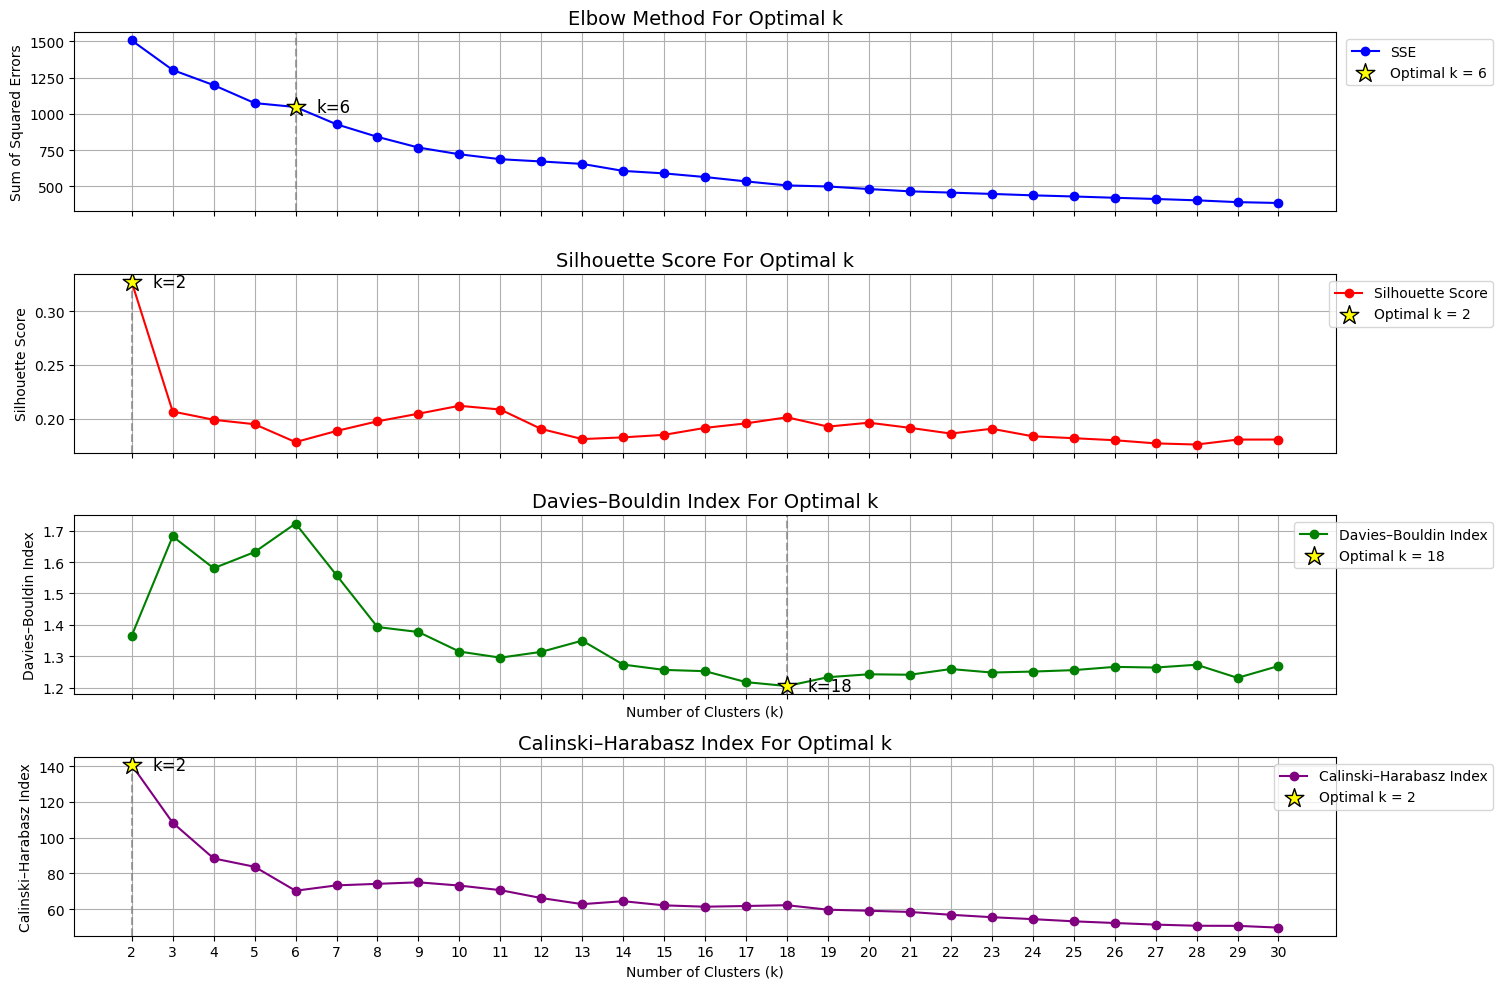

In [43]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# --- 1) Elbow Method (SSE) ---
axes[0].plot(k_values, sse, marker='o', color='b', label="SSE")
axes[0].scatter(
    optimal_k_elbow, sse_optimal, 
    s=200, marker='*', 
    color='yellow', edgecolors='black', linewidths=1, 
    zorder=10, label=f'Optimal k = {optimal_k_elbow}'
)
axes[0].axvline(optimal_k_elbow, color='gray', linestyle='--', alpha=0.7)
axes[0].text(
    optimal_k_elbow + 0.5, sse_optimal, 
    f"k={optimal_k_elbow}", 
    fontsize=12, 
    verticalalignment='center'
)
axes[0].set_ylabel("Sum of Squared Errors")
axes[0].set_title("Elbow Method For Optimal k", fontsize=14)
axes[0].grid(True)
axes[0].legend(loc='upper right', bbox_to_anchor=(1.13, 1.0))

# --- 2) Silhouette Score ---
axes[1].plot(k_values, sil_scores, marker='o', color='r', label="Silhouette Score")
axes[1].scatter(
    optimal_k_sil, sil_optimal, 
    s=200, marker='*', 
    color='yellow', edgecolors='black', linewidths=1, 
    zorder=10, label=f'Optimal k = {optimal_k_sil}'
)
axes[1].axvline(optimal_k_sil, color='gray', linestyle='--', alpha=0.7)
axes[1].text(
    optimal_k_sil + 0.5, sil_optimal, 
    f"k={optimal_k_sil}", 
    fontsize=12, 
    verticalalignment='center'
)
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score For Optimal k", fontsize=14)
axes[1].grid(True)
axes[1].legend(loc='upper right', bbox_to_anchor=(1.13, 1.0))

# --- 3) Davies–Bouldin Index ---
axes[2].plot(k_values, db_scores, marker='o', color='g', label="Davies–Bouldin Index")
axes[2].scatter(
    optimal_k_db, db_optimal, 
    s=200, marker='*', 
    color='yellow', edgecolors='black', linewidths=1, 
    zorder=10, label=f'Optimal k = {optimal_k_db}'
)
axes[2].axvline(optimal_k_db, color='gray', linestyle='--', alpha=0.7)
axes[2].text(
    optimal_k_db + 0.5, db_optimal, 
    f"k={optimal_k_db}", 
    fontsize=12, 
    verticalalignment='center'
)
axes[2].set_xlabel("Number of Clusters (k)")
axes[2].set_ylabel("Davies–Bouldin Index")
axes[2].set_title("Davies–Bouldin Index For Optimal k", fontsize=14)
axes[2].grid(True)
axes[2].legend(loc='upper right', bbox_to_anchor=(1.13, 1.0))

axes[3].plot(k_values, ch_scores, marker='o', color='purple', label="Calinski–Harabasz Index")
axes[3].scatter(
    optimal_k_ch, ch_optimal_value, 
    s=200, marker='*', 
    color='yellow', edgecolors='black', linewidths=1, 
    zorder=10, label=f'Optimal k = {optimal_k_ch}'
)
axes[3].axvline(optimal_k_ch, color='gray', linestyle='--', alpha=0.7)
axes[3].text(
    optimal_k_ch + 0.5, ch_optimal_value, 
    f"k={optimal_k_ch}", 
    fontsize=12, 
    verticalalignment='center'
)

axes[3].set_xlabel("Number of Clusters (k)")
axes[3].set_ylabel("Calinski–Harabasz Index")
axes[3].set_title("Calinski–Harabasz Index For Optimal k", fontsize=14)
axes[3].grid(True)
axes[3].legend(loc='upper right', bbox_to_anchor=(1.13, 1.0))

# Set common x-ticks across subplots
axes[3].set_xticks(k_values)

plt.tight_layout()
plt.savefig('data/experiment_result/kmeans_comparison_chart.png', dpi=150)
plt.show()

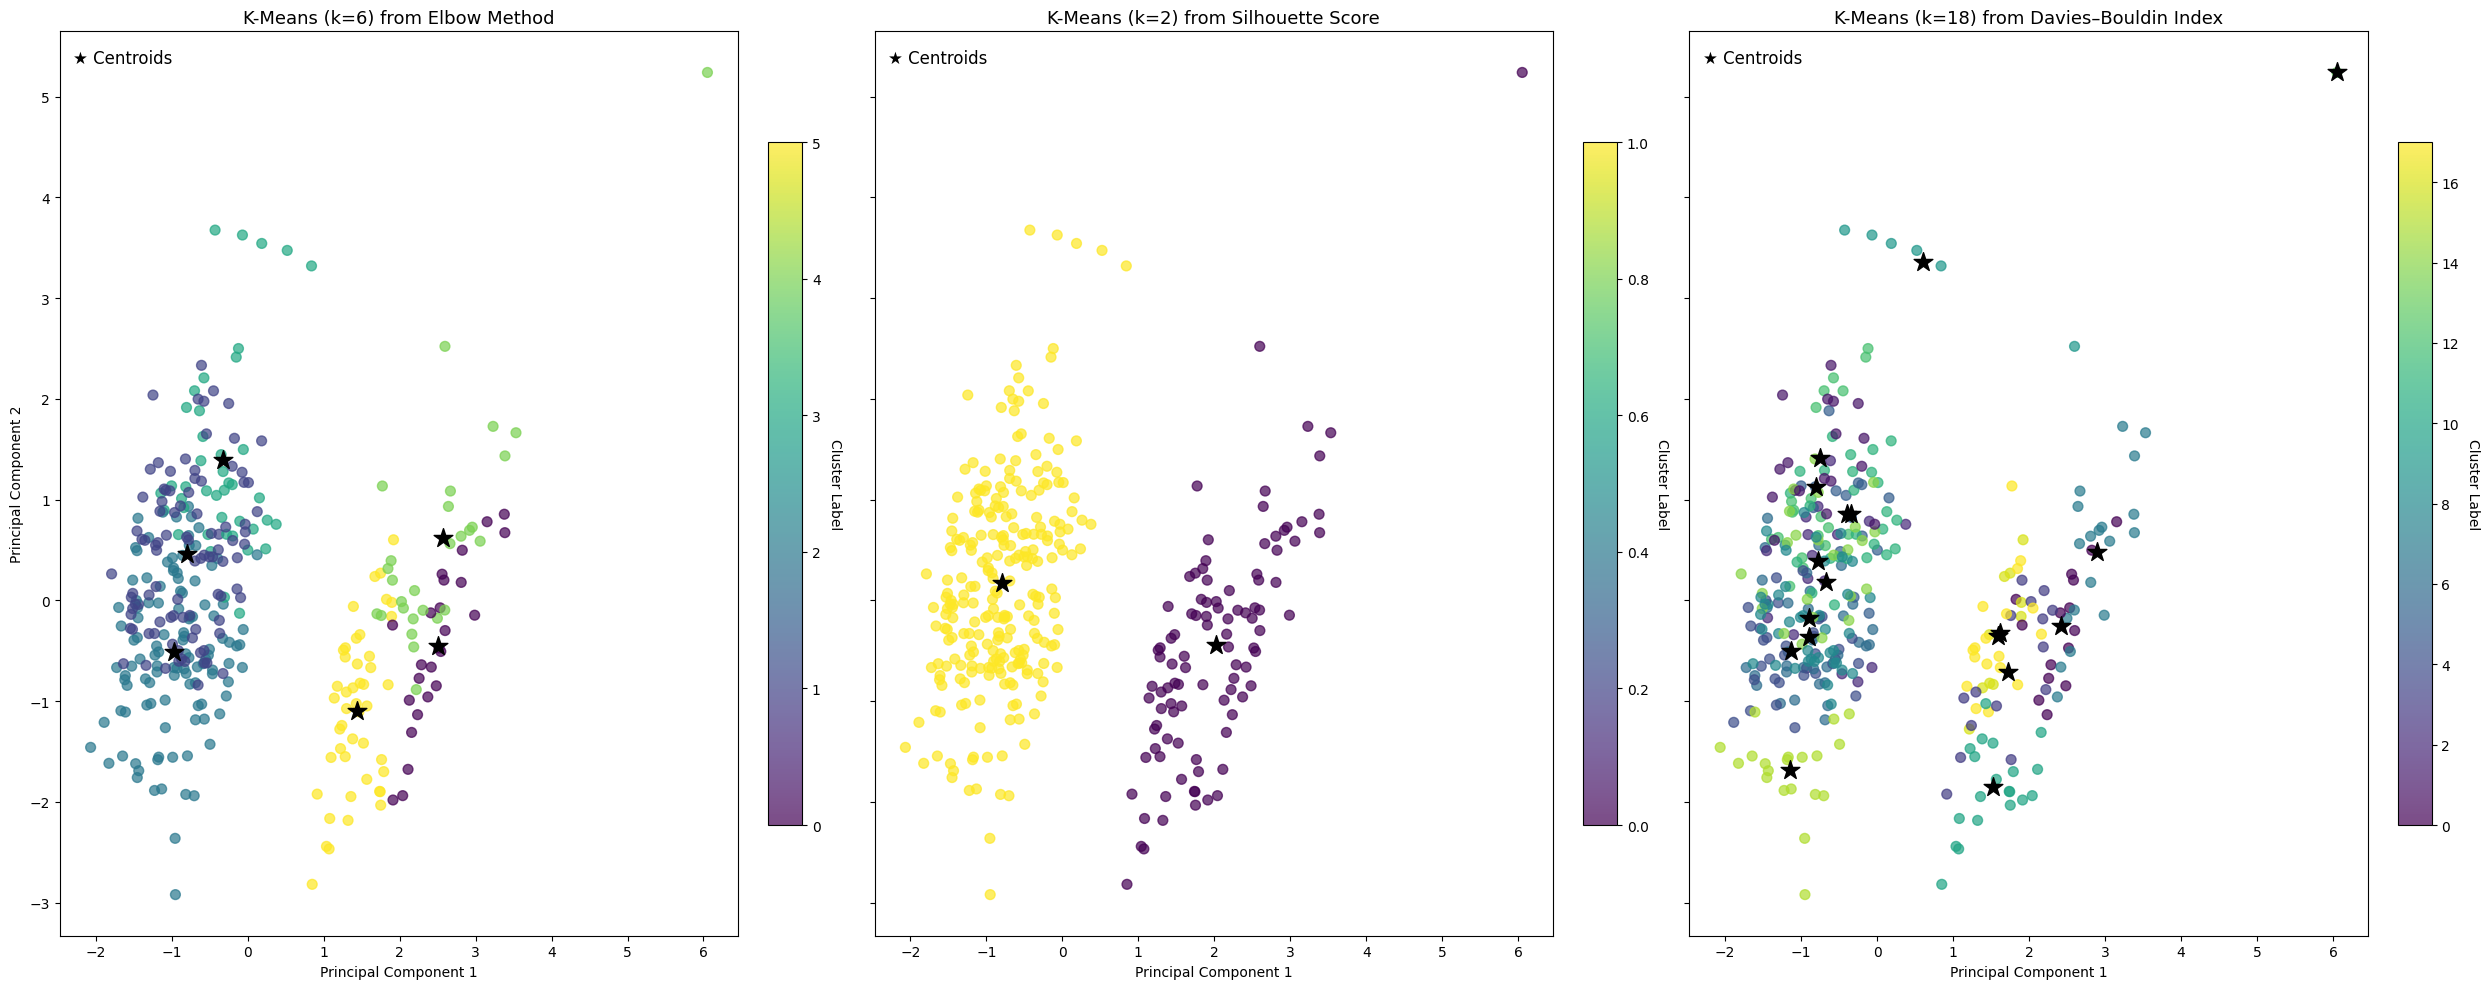

In [58]:
# Based on the elbow plot, choose an optimal number of clusters.
k_methods = [
    (optimal_k_elbow, "Elbow Method"),
    (optimal_k_sil, "Silhouette Score"),
    (optimal_k_db, "Davies–Bouldin Index")
]

# X_cluster_scaled is your scaled data for clustering
# Perform PCA once for consistent axes
pca = PCA(n_components=2, random_state=42)
X_pca_all = pca.fit_transform(X_cluster_scaled)

fig, axes = plt.subplots(1, 3, figsize=(25, 10), sharex=True, sharey=True)

for i, (k, method_name) in enumerate(k_methods):
    ax = axes[i]
    
    # Fit KMeans for the current k
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans_model.fit_predict(X_cluster_scaled)
    
    # Scatter plot of PCA-transformed data
    scatter = ax.scatter(
        X_pca_all[:, 0],
        X_pca_all[:, 1],
        c=clusters,
        cmap='viridis',
        alpha=0.7,
        s=50
    )

    # Plot cluster centroids in PCA space
    centers_2d = pca.transform(kmeans_model.cluster_centers_)
    ax.scatter(
        centers_2d[:, 0],
        centers_2d[:, 1],
        c='black',
        marker='*',
        s=200
    )

    # Title & labels
    ax.set_title(f"K-Means (k={k}) from {method_name}", fontsize=13)
    ax.set_xlabel("Principal Component 1")
    if i == 0:  
        ax.set_ylabel("Principal Component 2")

    # Add a colorbar for cluster labels
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Cluster Label', rotation=270, labelpad=15)
    
    # Place a small text label in the top-left corner indicating the black star is for centroids
    # Using Unicode star (U+2605) for a small star symbol
    ax.text(
        0.02, 0.98,  # x,y in Axes fraction
        u"\u2605 Centroids",  
        transform=ax.transAxes,
        color='black',
        fontsize=12,
        ha='left',
        va='top',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # optional background box
    )

plt.tight_layout()
plt.savefig('data\\experiment_result\\kmeans_pca_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

In [45]:
features_to_describe = ['DailyExpense', 'Rolling7', 'Lag1']

for k, model in k_methods:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    clusters = kmeans_model.fit_predict(X_cluster_scaled)
    col_name = f'Cluster_{model}_{k}'
    
    print(f'\n{col_name}')
    # Print counts of samples per cluster
    print(pd.Series(clusters).value_counts())
    
    # Optionally add the cluster labels to your DataFrame for further analysis
    daily_expense[col_name] = clusters
    
    # Use .describe() to calculate count, mean, std, min, 25%, 50%, 75%, and max
    stats = daily_expense.groupby(col_name)[features_to_describe].describe().round(2)
    print("\nDescriptive statistics:")
    print(stats)
    
    # Alternatively, if you want to compute specific metrics using .agg():
    custom_stats = daily_expense.groupby(col_name)[features_to_describe].agg({
        'DailyExpense': ['mean', 'std', 'min', 'max', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
        'Rolling7': ['mean', 'std', 'min', 'max', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)],
        'Lag1': ['mean', 'std', 'min', 'max', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)]
    })
    # Rename the lambda columns for clarity
    custom_stats.columns = ['_'.join(col).strip() for col in custom_stats.columns.values]
    print("\nCustom statistics:")
    print(custom_stats)


Cluster_Elbow Method_6
2    115
1     96
5     46
3     42
4     28
0     25
Name: count, dtype: int64

Descriptive statistics:
                       DailyExpense                                        \
                              count    mean     std    min     25%    50%   
Cluster_Elbow Method_6                                                      
0                              25.0  260.92   50.41  195.0  218.00  251.0   
1                              96.0  220.35   34.43  168.0  190.75  221.0   
2                             115.0  220.47   31.00  168.0  193.50  221.0   
3                              42.0  231.38   30.98  170.0  210.00  239.5   
4                              28.0  309.14  103.65  195.0  256.75  296.5   
5                              46.0  320.24   59.16  191.0  283.00  316.0   

                                      Rolling7          ...                  \
                           75%    max    count    mean  ...     75%     max   
Cluster_Elbow Metho

## Comparing How Cluster Assignments Change from k to k+1

In [46]:
assignment_changes = []
previous_labels = None
previous_k = None

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_cluster_scaled)
    
    if previous_labels is not None:
        # Count how many labels differ
        changes = np.sum(labels != previous_labels)
        fraction_changed = changes / len(labels)
        assignment_changes.append((previous_k, k, fraction_changed))
    
    previous_labels = labels
    previous_k = k

# Convert to a DataFrame for easier reading
changes_df = pd.DataFrame(assignment_changes, columns=["k_old", "k_new", "fraction_changed"])
print("Fraction of points changing clusters when going from k to k+1:")
print(changes_df)

Fraction of points changing clusters when going from k to k+1:
    k_old  k_new  fraction_changed
0       2      3          0.352273
1       3      4          0.116477
2       4      5          0.116477
3       5      6          0.221591
4       6      7          0.301136
5       7      8          0.735795
6       8      9          0.187500
7       9     10          0.090909
8      10     11          0.116477
9      11     12          0.076705
10     12     13          0.150568
11     13     14          0.025568
12     14     15          0.142045
13     15     16          0.110795
14     16     17          0.036932
15     17     18          0.073864
16     18     19          0.079545
17     19     20          0.056818
18     20     21          0.792614
19     21     22          0.068182
20     22     23          0.076705
21     23     24          0.085227
22     24     25          0.105114
23     25     26          0.059659
24     26     27          0.062500
25     27     28          0

In [47]:
# Identify the row with the maximum fraction_changed
max_idx = changes_df['fraction_changed'].idxmax()
max_k = changes_df.loc[max_idx, 'k_new']
max_val = changes_df.loc[max_idx, 'fraction_changed']
print(f"Maximum change in cluster assignments occurs when going from k={max_k-1} to k={max_k} ({max_val:.2%} change)")

Maximum change in cluster assignments occurs when going from k=20 to k=21 (79.26% change)


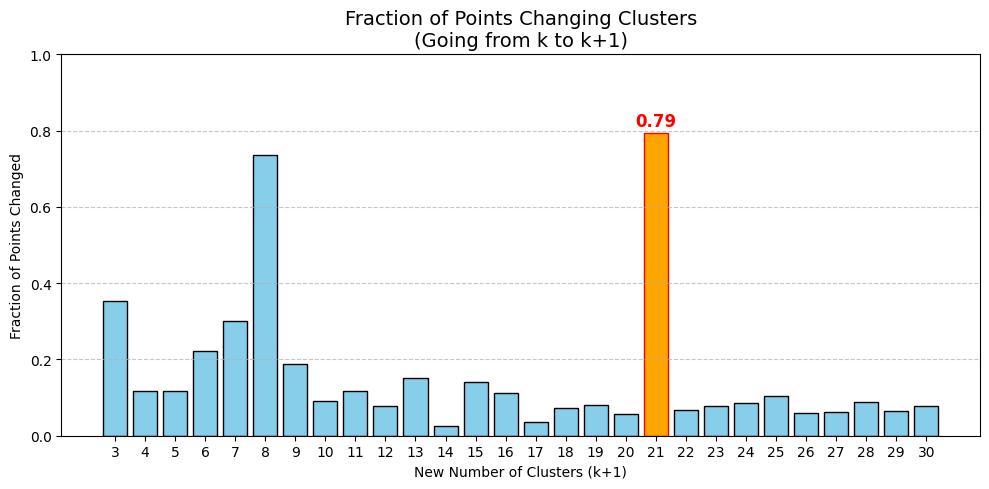

In [48]:
plt.figure(figsize=(10, 5))

# Create a bar chart
bars = plt.bar(
    changes_df['k_new'], 
    changes_df['fraction_changed'], 
    color='skyblue', 
    edgecolor='black'
)

# Highlight the bar with the maximum fraction changed
for bar in bars:
    bar_center = bar.get_x() + bar.get_width()/2
    if np.isclose(bar_center, max_k, atol=0.1):
        bar.set_color('orange')
        bar.set_edgecolor('red')

# Annotate the highest bar
plt.text(
    max_k, 
    max_val + 0.02,  # Slightly above the bar
    f"{max_val:.2f}", 
    ha='center', 
    color='red',
    fontsize=12,
    fontweight='bold'
)

plt.title("Fraction of Points Changing Clusters\n(Going from k to k+1)", fontsize=14)
plt.xlabel("New Number of Clusters (k+1)")
plt.ylabel("Fraction of Points Changed")
plt.ylim(0, 1)  # Fractions range from 0 to 1
plt.xticks(changes_df['k_new'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('data/experiment_result/cluster_assignment_changes.png', dpi=150)
plt.show()

## Cluster on First X Month, Then See How The Data Fits

In [49]:
cutoff_date = pd.to_datetime("2025-06-01")
train_data = daily_expense[daily_expense['Date'] < cutoff_date].copy()
test_data = daily_expense[daily_expense['Date'] >= cutoff_date].copy()

# Scale them separately or together, depending on your approach
scaler = StandardScaler()
train_features = train_data[cluster_features]
test_features = test_data[cluster_features]

X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

k = 6  # or your chosen k
kmeans_split = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_split.fit(X_train_scaled)

# Assign clusters to training data
train_clusters = kmeans_split.predict(X_train_scaled)
train_data['Cluster'] = train_clusters

# Assign clusters to test data
test_clusters = kmeans_split.predict(X_test_scaled)
test_data['Cluster'] = test_clusters

print("Training cluster distribution:")
print(train_data['Cluster'].value_counts())

print("\nTest cluster distribution:")
print(test_data['Cluster'].value_counts())

Training cluster distribution:
Cluster
0    31
5    26
3    26
1    24
4    22
2    16
Name: count, dtype: int64

Test cluster distribution:
Cluster
4    115
3     47
1     23
2     22
Name: count, dtype: int64


### Check for 2, 4, 6, 8, 10 Months

In [50]:
offsets = [2, 4, 6, 8, 10]

start_date = daily_expense['Date'].min()
split_results = {}

In [51]:
# Loop over each offset to compute cluster assignments and count samples per cluster
for offset in offsets:
    cutoff_date = start_date + pd.DateOffset(months=offset)
    
    # Split the data
    train_data = daily_expense[daily_expense['Date'] < cutoff_date].copy()
    test_data = daily_expense[daily_expense['Date'] >= cutoff_date].copy()
    
    # Scale the features (fit scaler on train and transform test)
    scaler = StandardScaler()
    train_features = train_data[cluster_features]
    test_features = test_data[cluster_features]
    
    X_train_scaled = scaler.fit_transform(train_features)
    X_test_scaled = scaler.transform(test_features)
    
    # Fit K-Means on training data with chosen k (e.g., 6)
    k = 6
    kmeans_split = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_split.fit(X_train_scaled)
    
    # Predict clusters for training and test data
    train_clusters = kmeans_split.predict(X_train_scaled)
    test_clusters = kmeans_split.predict(X_test_scaled)
    
    train_data['Cluster'] = train_clusters
    test_data['Cluster'] = test_clusters
    
    # Count samples per cluster
    train_counts = train_data['Cluster'].value_counts().sort_index()
    test_counts = test_data['Cluster'].value_counts().sort_index()
    
    # Store results for this offset
    split_results[offset] = {
        'cutoff_date': cutoff_date, 
        'train_counts': train_counts, 
        'test_counts': test_counts
    }

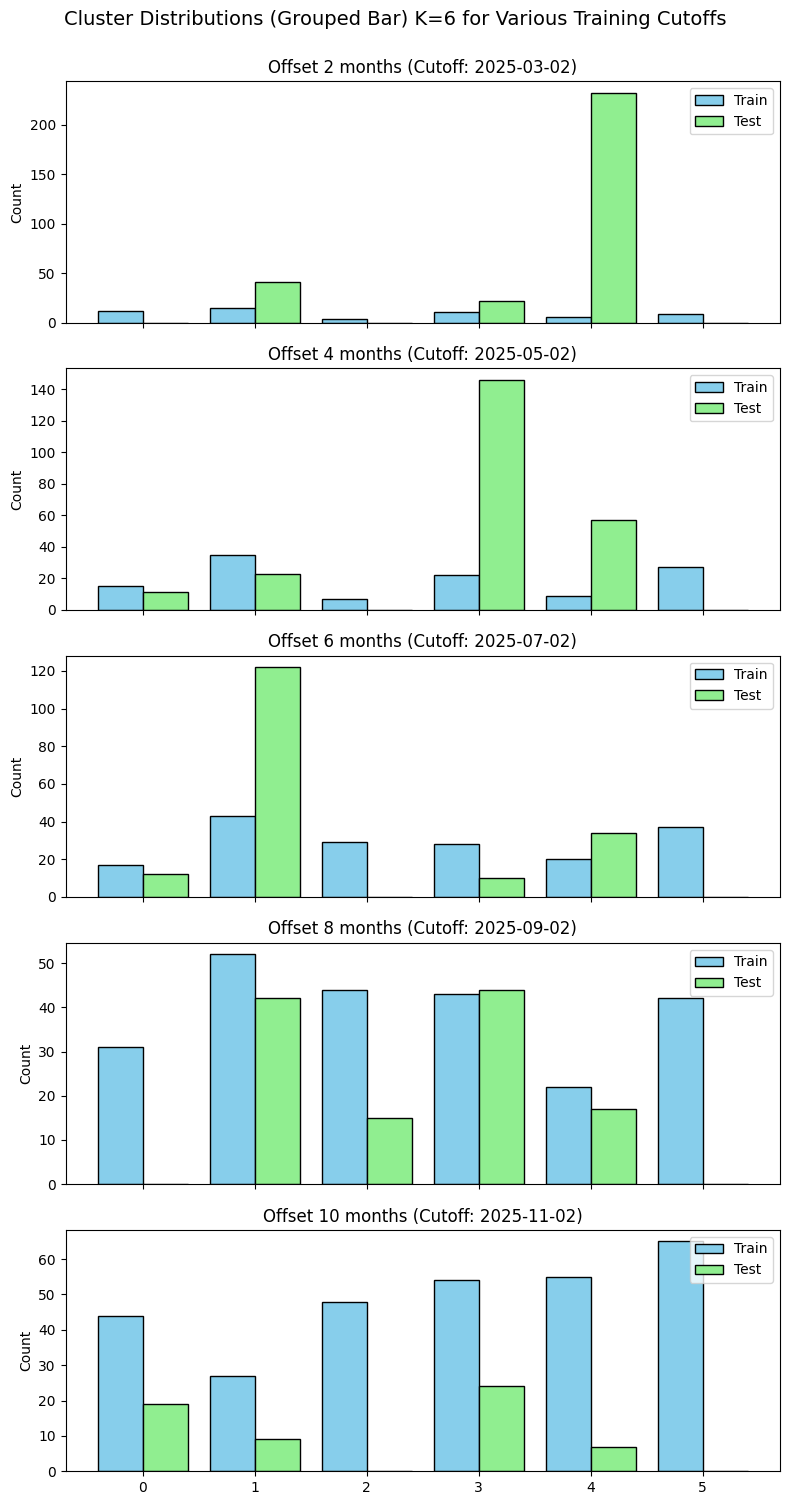

In [52]:
fig, axes = plt.subplots(nrows=len(offsets), ncols=1, figsize=(8, 3 * len(offsets)), sharex=True)

x_positions = np.arange(k)  # k is the number of clusters, e.g. 6
bar_width = 0.4

for i, offset in enumerate(offsets):
    result = split_results[offset]
    cutoff_date = result['cutoff_date']
    train_counts = result['train_counts']
    test_counts = result['test_counts']
    
    # Ensure both Series cover all clusters [0..k-1], fill missing with 0
    train_counts = train_counts.reindex(range(k), fill_value=0)
    test_counts = test_counts.reindex(range(k), fill_value=0)
    
    ax = axes[i] if len(offsets) > 1 else axes  # handle single-subplot case
    
    # Plot grouped bars
    ax.bar(x_positions - bar_width/2, train_counts.values, width=bar_width, 
           color='skyblue', edgecolor='black', label='Train')
    ax.bar(x_positions + bar_width/2, test_counts.values, width=bar_width, 
           color='lightgreen', edgecolor='black', label='Test')
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels([str(c) for c in range(k)])
    ax.set_ylabel("Count")
    ax.set_title(f"Offset {offset} months (Cutoff: {cutoff_date.date()})")
    ax.legend(loc='upper right')
    
plt.suptitle("Cluster Distributions (Grouped Bar) K=6 for Various Training Cutoffs", fontsize=14, y=1)
plt.savefig('data/experiment_result/train_test_cluster_distribution_k_6.png', dpi=150, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Check for 2, 4, 6, 8, 10 Months Using K=6 and K=2

In [54]:
offsets = [2, 4, 6, 8, 10]
k_vals = [2, 6]
start_date = daily_expense['Date'].min()

split_results = {offset: {} for offset in offsets}

In [55]:
for offset in offsets:
    cutoff_date = start_date + pd.DateOffset(months=offset)
    
    # Split the data
    train_data = daily_expense[daily_expense['Date'] < cutoff_date].copy()
    test_data = daily_expense[daily_expense['Date'] >= cutoff_date].copy()
    
    # Scale the features (fit scaler on train, then transform test)
    scaler = StandardScaler()
    train_features = train_data[cluster_features]
    test_features = test_data[cluster_features]
    
    X_train_scaled = scaler.fit_transform(train_features)
    X_test_scaled = scaler.transform(test_features)
    
    for k in k_vals:
        # Fit K-Means on training data
        kmeans_split = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans_split.fit(X_train_scaled)
        
        # Predict clusters for training and test data
        train_clusters = kmeans_split.predict(X_train_scaled)
        test_clusters = kmeans_split.predict(X_test_scaled)
        
        # Count samples per cluster
        train_counts = pd.Series(train_clusters).value_counts().sort_index()
        test_counts = pd.Series(test_clusters).value_counts().sort_index()
        
        # Store the results
        split_results[offset][k] = {
            'cutoff_date': cutoff_date,
            'train_counts': train_counts,
            'test_counts': test_counts
        }

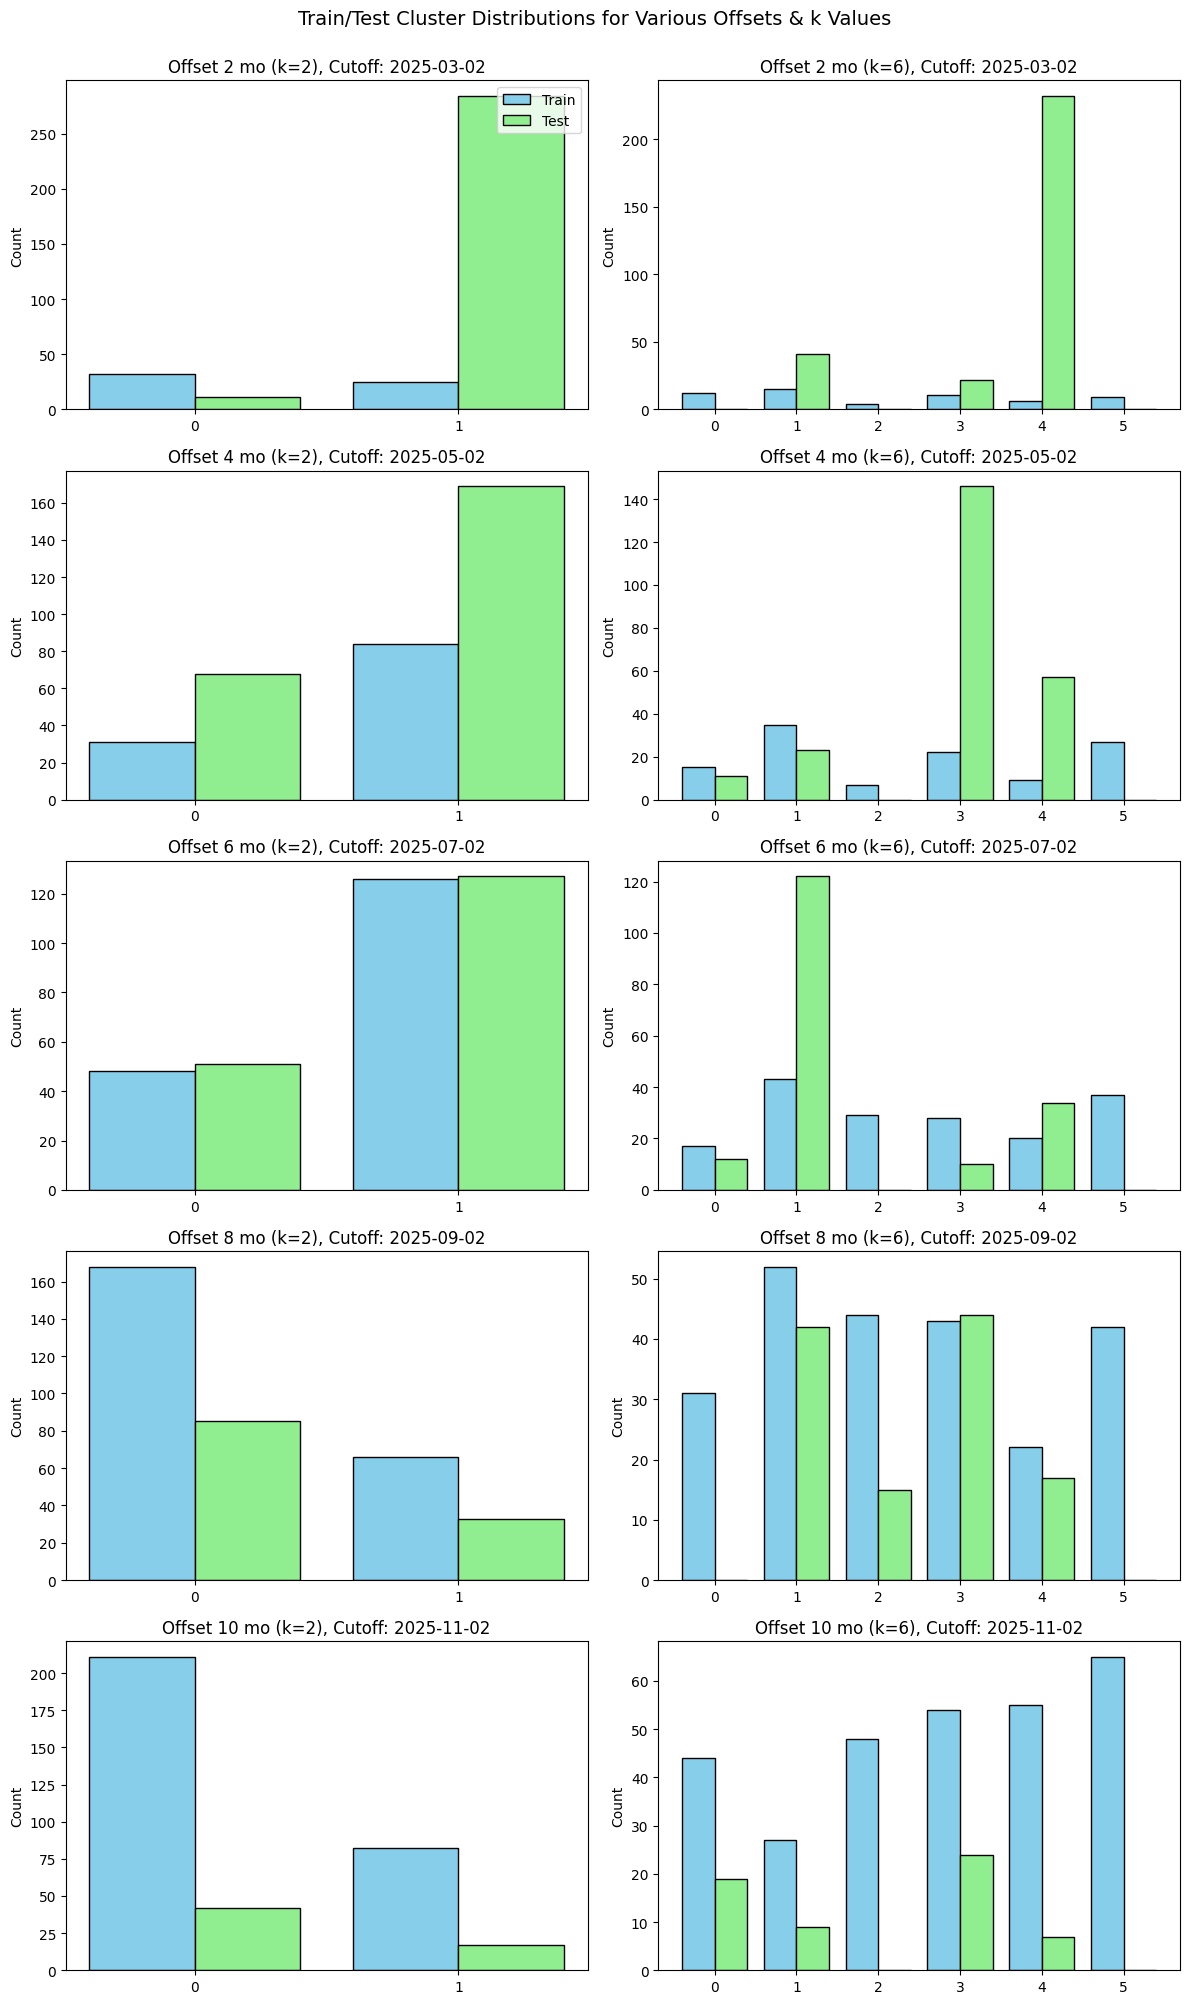

In [56]:
n_offsets = len(offsets)
n_kvals = len(k_vals)
fig, axes = plt.subplots(
    nrows=n_offsets, ncols=n_kvals, 
    figsize=(12, 4 * n_offsets), 
    sharex=False, sharey=False
)

bar_width = 0.4

for i, offset in enumerate(offsets):
    for j, k in enumerate(k_vals):
        ax = axes[i, j] if n_offsets > 1 else axes[j]  # handle single-row case
        results = split_results[offset][k]
        
        cutoff_date = results['cutoff_date']
        train_counts = results['train_counts']
        test_counts = results['test_counts']
        
        # Ensure we have a count for each cluster index [0..k-1]
        train_counts = train_counts.reindex(range(k), fill_value=0)
        test_counts = test_counts.reindex(range(k), fill_value=0)
        
        x_positions = np.arange(k)
        
        # Grouped bar chart: train vs test
        ax.bar(
            x_positions - bar_width/2, 
            train_counts.values, 
            width=bar_width, 
            color='skyblue', 
            edgecolor='black', 
            label='Train'
        )
        ax.bar(
            x_positions + bar_width/2, 
            test_counts.values, 
            width=bar_width, 
            color='lightgreen', 
            edgecolor='black', 
            label='Test'
        )
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels([str(c) for c in range(k)])
        ax.set_ylabel("Count")
        ax.set_title(f"Offset {offset} mo (k={k}), Cutoff: {cutoff_date.date()}")
        
        if i == 0 and j == 0:
            ax.legend(loc='upper right')

plt.suptitle("Train/Test Cluster Distributions for Various Offsets & k Values", fontsize=14, y=1)
plt.savefig('data/experiment_result/train_test_cluster_distribution_multiple_offsets_and_k_vals.png', dpi=150, bbox_inches='tight')
plt.tight_layout()
plt.show()

# GMM (Gaussian Mixture Model)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
cluster_features = ['DayOfWeek', 'IsWeekend', 'Month', 'Day', 'Rolling7', 'Lag1']

In [ ]:
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(daily_expense[cluster_features])

In [ ]:
n_components = 6

In [ ]:
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_cluster_scaled)

GaussianMixture(n_components=6, random_state=42)

In [ ]:
# Predict cluster labels and get the membership probabilities
gmm_labels = gmm.predict(X_cluster_scaled)
gmm_probabilities = gmm.predict_proba(X_cluster_scaled)

# Add the GMM cluster assignments and probabilities to your DataFrame
daily_expense['GMM_Cluster'] = gmm_labels
# For example, you might store the maximum probability (confidence) for each point
daily_expense['GMM_Confidence'] = gmm_probabilities.max(axis=1)

print("GMM Cluster distribution:")
print(daily_expense['GMM_Cluster'].value_counts())

# Optionally, display the first few rows with cluster labels and confidence
print(daily_expense[['Date', 'DailyExpense', 'GMM_Cluster', 'GMM_Confidence']].head())

GMM Cluster distribution:
GMM_Cluster
2    132
1     99
0     49
5     47
3     22
4      3
Name: count, dtype: int64
        Date  DailyExpense  GMM_Cluster  GMM_Confidence
1 2025-01-02           206            2        0.999993
2 2025-01-03           195            2        0.999993
3 2025-01-04           295            5        1.000000
4 2025-01-05           263            0        1.000000
5 2025-01-06           230            2        0.999994


### Descriptive Statistics

In [ ]:
features_numeric = ['DailyExpense', 'Rolling7', 'Lag1']
print("=== Numeric Descriptive Statistics by Cluster ===")
profile_stats = daily_expense.groupby('GMM_Cluster')[features_numeric].describe().round(2)
print(profile_stats)

=== Numeric Descriptive Statistics by Cluster ===
            DailyExpense                                                       \
                   count    mean     std    min     25%    50%     75%    max   
GMM_Cluster                                                                     
0                   49.0  268.43   54.05  191.0  222.00  258.0  309.00  403.0   
1                   99.0  220.91   34.25  169.0  191.00  221.0  243.00  304.0   
2                  132.0  223.13   31.51  168.0  194.75  227.0  246.25  303.0   
3                   22.0  222.86   31.15  168.0  200.50  217.5  245.75  289.0   
4                    3.0  442.00  276.22  253.0  283.50  314.0  536.50  759.0   
5                   47.0  328.32   52.77  245.0  292.50  321.0  358.00  451.0   

            Rolling7          ...                   Lag1                  \
               count    mean  ...     75%     max  count    mean     std   
GMM_Cluster                   ...                                   

In [ ]:
# For categorical features, calculate percentages (e.g., DayOfWeek, IsWeekend)
categorical_features = ['DayOfWeek', 'IsWeekend', 'Month', 'Day']
print("\n=== Categorical Distribution by Cluster (in %): ===")
cat_profile = daily_expense.groupby('GMM_Cluster')[categorical_features].agg(
    lambda x: x.value_counts(normalize=True).mul(100).round(2).to_dict()
)
print(cat_profile)


=== Categorical Distribution by Cluster (in %): ===
                                                     DayOfWeek   IsWeekend  \
GMM_Cluster                                                                  
0                                                   {6: 100.0}  {1: 100.0}   
1            {4: 24.24, 3: 23.23, 1: 21.21, 2: 20.2, 0: 11.11}  {0: 100.0}   
2              {3: 20.45, 2: 20.45, 4: 19.7, 0: 19.7, 1: 19.7}  {0: 100.0}   
3             {0: 59.09, 2: 18.18, 1: 13.64, 3: 4.55, 4: 4.55}  {0: 100.0}   
4                                         {6: 66.67, 5: 33.33}  {1: 100.0}   
5                                                   {5: 100.0}  {1: 100.0}   

                                                         Month  \
GMM_Cluster                                                      
0            {3: 10.2, 8: 10.2, 1: 8.16, 2: 8.16, 4: 8.16, ...   
1            {11: 19.19, 12: 19.19, 9: 18.18, 8: 17.17, 10:...   
2            {1: 16.67, 3: 15.91, 4: 15.91, 2: 15.15, 5: 1

In [ ]:
# Investigate a small cluster (e.g., Cluster 4)
print("\n=== Detailed Profile for Cluster 4 ===")
cluster_4 = daily_expense[daily_expense['GMM_Cluster'] == 4]
print(cluster_4.describe())


=== Detailed Profile for Cluster 4 ===
                      Date  DailyExpense  DayOfWeek  IsWeekend      Month  \
count                    3      3.000000   3.000000        3.0   3.000000   
mean   2025-10-18 16:00:00    442.000000   5.666667        1.0  10.333333   
min    2025-10-11 00:00:00    253.000000   5.000000        1.0  10.000000   
25%    2025-10-11 12:00:00    283.500000   5.500000        1.0  10.000000   
50%    2025-10-12 00:00:00    314.000000   6.000000        1.0  10.000000   
75%    2025-10-22 12:00:00    536.500000   6.000000        1.0  10.500000   
max    2025-11-02 00:00:00    759.000000   6.000000        1.0  11.000000   
std                    NaN    276.219116   0.577350        0.0   0.577350   

             Day        Lag1    Rolling7  LogExpense  GMM_Cluster  \
count   3.000000    3.000000    3.000000    3.000000          3.0   
mean    8.333333  419.333333  297.666667    5.974408          4.0   
min     2.000000  244.000000  261.142857    5.537334       

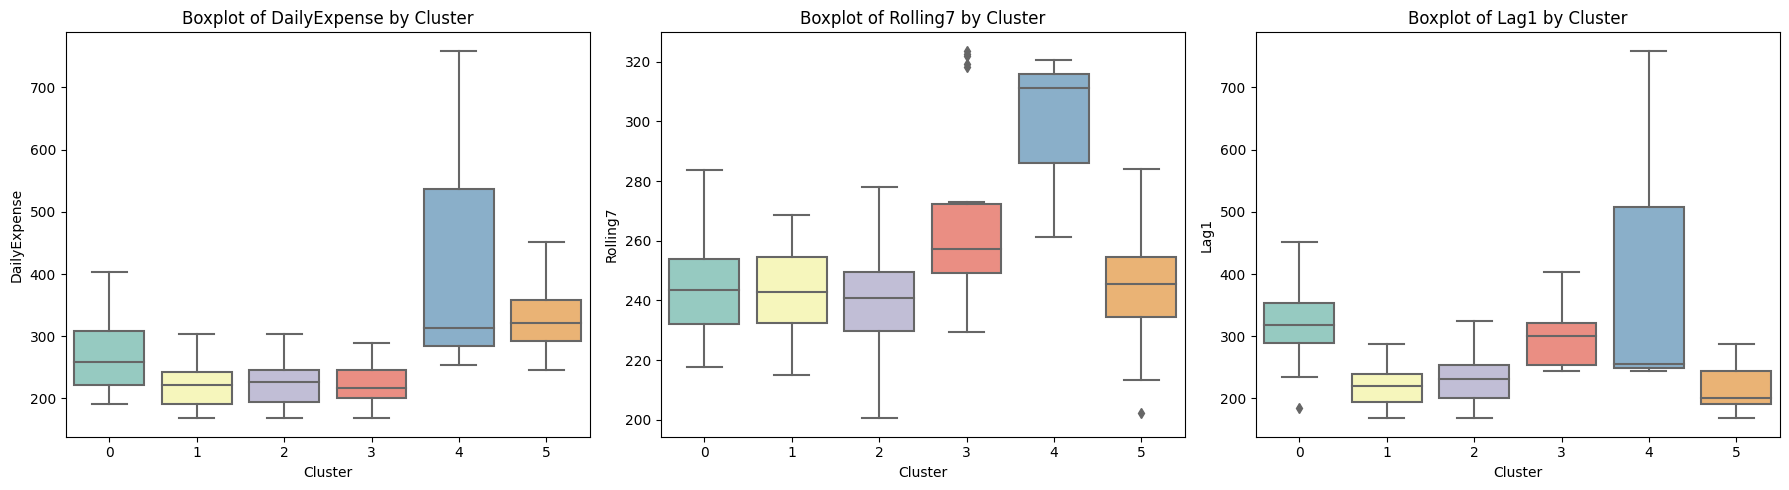

In [ ]:
plt.figure(figsize=(18, 5))
for i, feat in enumerate(features_numeric):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='GMM_Cluster', y=feat, data=daily_expense, palette='Set3')
    plt.title(f"Boxplot of {feat} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feat)
plt.tight_layout()
plt.show()

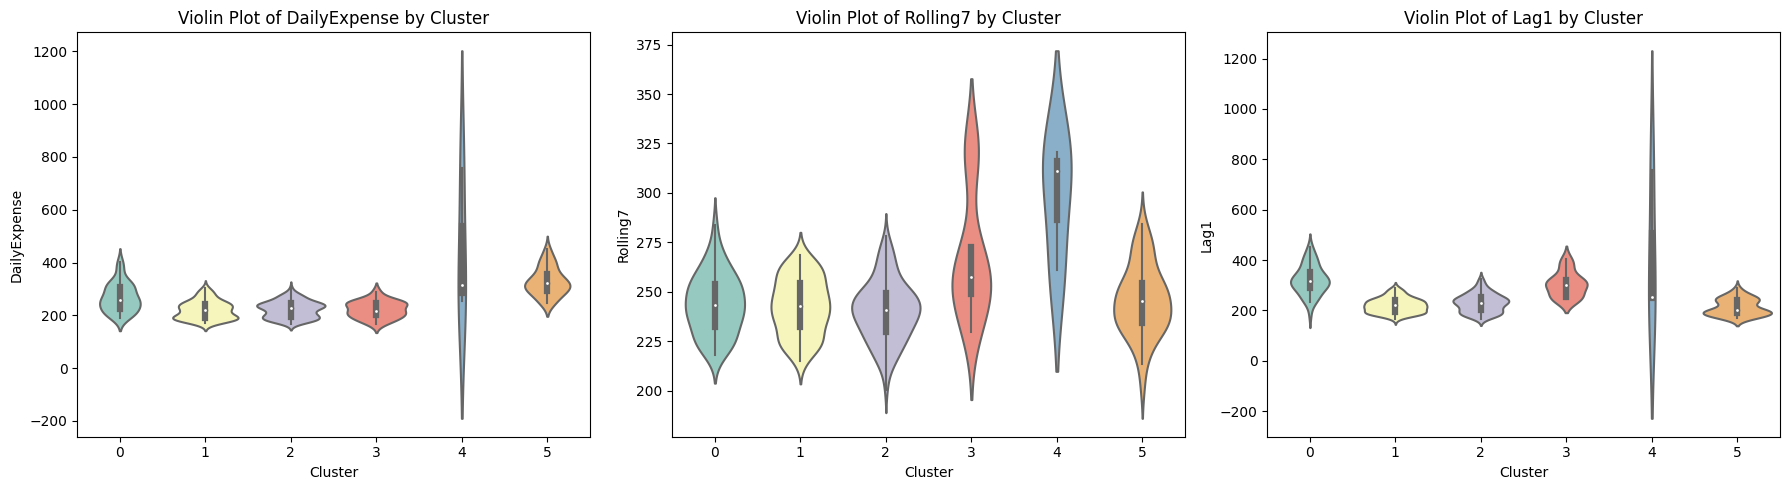

In [ ]:
plt.figure(figsize=(18, 5))
for i, feat in enumerate(features_numeric):
    plt.subplot(1, 3, i+1)
    sns.violinplot(x='GMM_Cluster', y=feat, data=daily_expense, palette='Set3')
    plt.title(f"Violin Plot of {feat} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feat)
plt.tight_layout()
plt.show()

C:\Users\Davon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Davon\AppData\Local\Temp\ipykernel_17252\3102834032.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


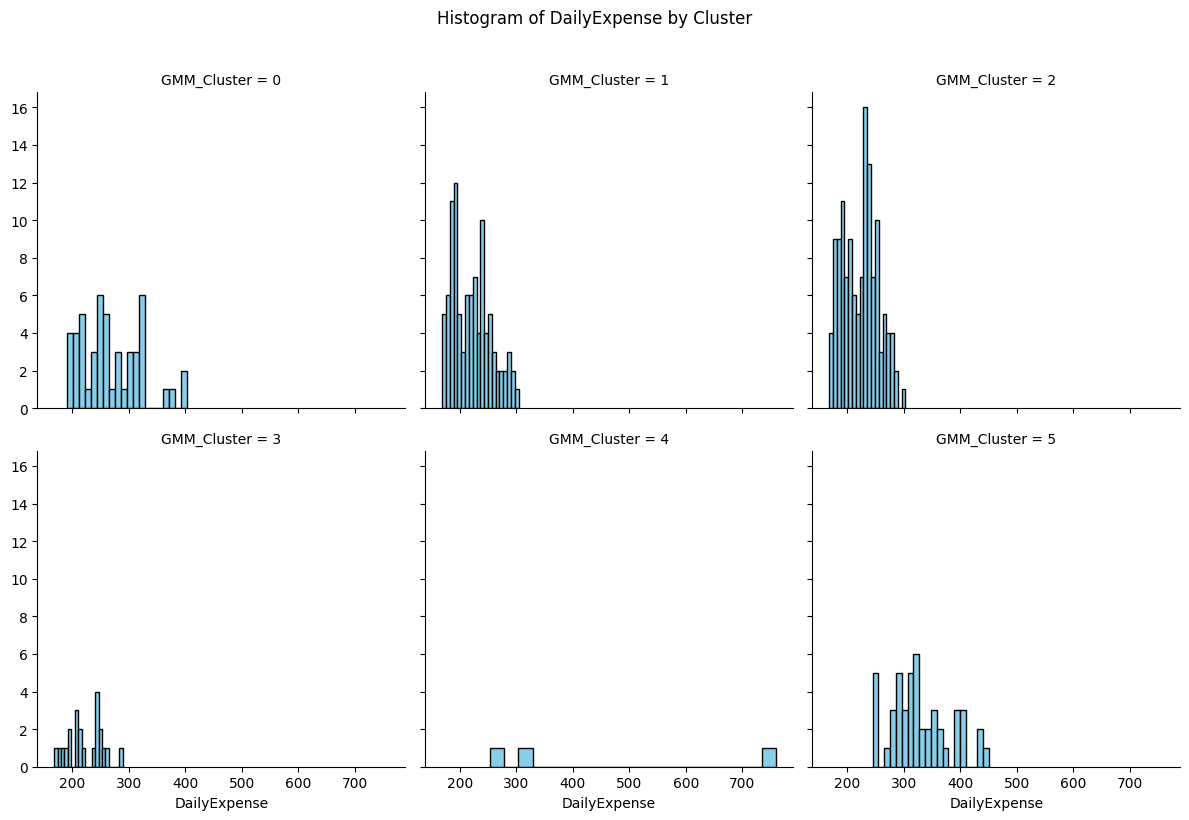

In [ ]:
g = sns.FacetGrid(daily_expense, col="GMM_Cluster", col_wrap=3, height=4)
g.map(plt.hist, "DailyExpense", bins=20, color='skyblue', edgecolor='black')
g.fig.suptitle("Histogram of DailyExpense by Cluster", y=1.02)
plt.tight_layout()
plt.show()

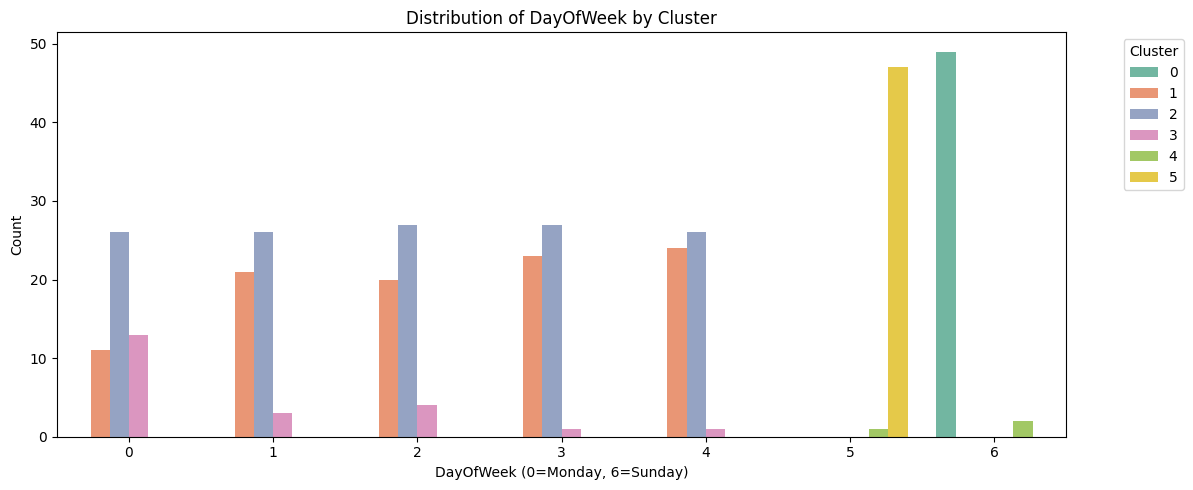

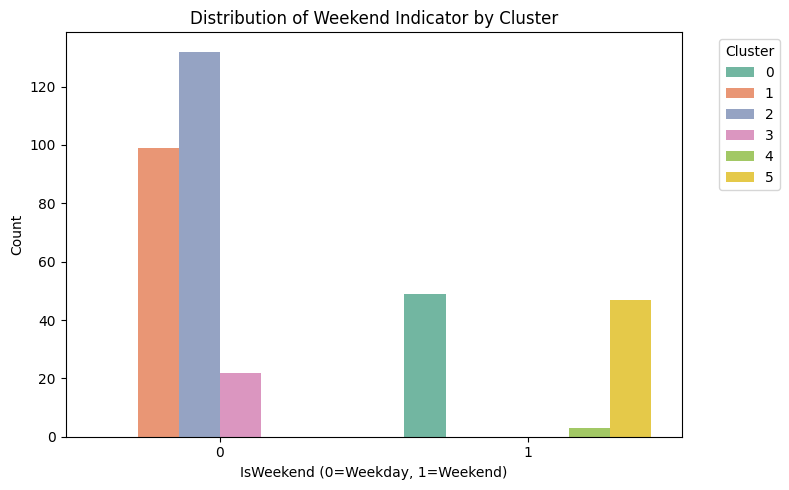

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(x='DayOfWeek', hue='GMM_Cluster', data=daily_expense, palette='Set2')
plt.title("Distribution of DayOfWeek by Cluster")
plt.xlabel("DayOfWeek (0=Monday, 6=Sunday)")
plt.ylabel("Count")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='IsWeekend', hue='GMM_Cluster', data=daily_expense, palette='Set2')
plt.title("Distribution of Weekend Indicator by Cluster")
plt.xlabel("IsWeekend (0=Weekday, 1=Weekend)")
plt.ylabel("Count")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Radar Chart for Cluster Mean Profiles

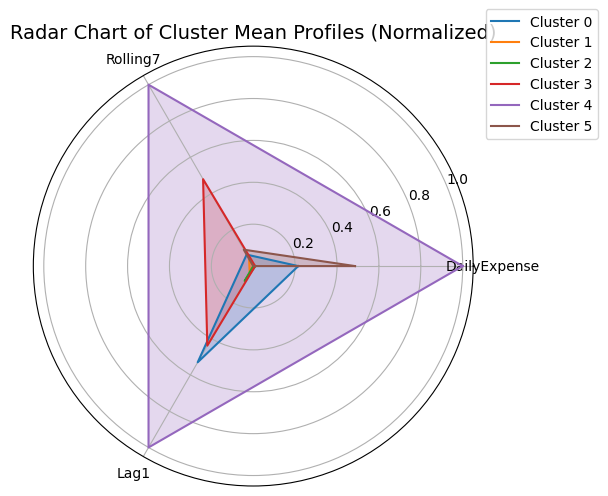

In [ ]:
features_radar = ['DailyExpense', 'Rolling7', 'Lag1']
cluster_means = daily_expense.groupby('GMM_Cluster')[features_radar].mean().reset_index()

# Normalize each feature (min-max normalization) for fair comparison
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

for feat in features_radar:
    cluster_means[feat] = normalize(cluster_means[feat])

# Prepare the angles for the radar chart
num_vars = len(features_radar)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, row in cluster_means.iterrows():
    values = row[features_radar].tolist()
    values += values[:1]  # close the circle
    ax.plot(angles, values, label=f"Cluster {int(row['GMM_Cluster'])}")
    ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), features_radar)
ax.set_title("Radar Chart of Cluster Mean Profiles (Normalized)", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()